<a href="https://colab.research.google.com/github/passerim/CORD-19-KaggleExperiment/blob/master/CORD_19_KaggleExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Open Research Dataset Challenge (CORD-19)
An AI challenge with AI2, CZI, MSR, Georgetown, NIH & The White House

### Analisi del dataset CORD-19 pubblicato sul sito Kaggle, per rispondere a domande sulla diffusione e sulla natura del nuovo virus SARS-CoV-2, facendo uso di tecniche di Natural Language Processing

## Descrizione del problema ed approccio risolutivo
Il dataset CORD-19 è un dataset molto vasto ed in continua crescita, che raggruppa attualmente oltre 200 mila articoli scientifici pubblicati prevalentemente dal 2000 fino ad oggi, riguardo a temi che coinvolgono il nuovo virus SARS-CoV-2 e la famiglia dei coronavirus. 

L'obiettivo dello studio è la costruzione di un sistema, in un notebook Python, che sia in grado di rispondere, tramite utilizzo di tecniche di Text Mining e NLP, a domande espresse in linguaggio naturale.<br>
Con la rapida crescita della letteratura scientifica su questo nuovo coronavirus, questi sistemi sono fondamentali per supportare il personale medico nella ricerca di informazioni utili e risposte a domande chiave.  

L'analisi del dataset presenta una serie di difficoltà specifiche e richiede un'attenta e preventiva definizione di un approccio da seguire per ricavarne informazioni utili.

Il dataset comprende diverse migliaria di articoli, per ciascuno dei quali sono presenti varie informazioni, oltre a titolo, abstract e full-text.<br>
Si vuole implementare un motore di ricerca che consenta di reperire gli articoli più pertinenti ad una query dell'utente o ad una domanda formulata in linguaggio naturale.<br>Per questo scopo ci si può limitare a considerare per ogni articolo solo l'abstract ed il titolo, questa scelta porta diversi vantaggi: l'abstract dovrebbe essere un riassunto del full text di un articolo e quindi contenere gran parte dell'informazione e delle parole chiave dell'articolo, l'abstract è di norma più corto dell'articolo e questo permette di contenere la dimensione dei dati su cui operare.

### Criticità:
*   Elevato numero di articoli.
*   Gli articoli hanno carattere scientifico e fortemente tecnico. In essi sono presenti termini del gergo medico, tecnicismi, definizioni, sigle e valori.
*   Gli articoli trattano tematiche diverse ma prevalentemente nel campo della virologia, questo comporta che i temi di cui i diversi articoli trattano siano fortemente sovrapposti.

### Opportunità:
*   File `metadata.csv` contenente diverse informazioni-chiave su ciascun articolo tra cui titolo e abstract.
*   Presenza di abstract per ogni articolo che riassume il contenuto del full-text.

### Modelli:
Il problema specifico che si affronta è un problema di apprendimento non supervisionato poiché si vuole estrarre conoscenza da un insieme di dati non etichettati.<br>
Si costruiscono cinque diversi modelli di learning per NLP e Text Mining:
1.   Latent Semantic Analysis (LSA)
2.   Probabilistic Latent Semantic Analysis (pLSA),implementata con Non-negative Matrix Factorization
3.   Word Embedding basato su PMI e SVD
4.   Ensemble LSA e SVD-PMI
5.   Word2vec

#### Approccio:
1.   Si caricano i dati degli articoli dal file
`metadata.csv`.
2.   Si studiano i dati in possesso e si evidenziano eventuali problematiche come dati mancanti, incompleti e poco significativi.
2.   Si procede alla fase pulitura, tokenizzazione, lemmatizzazione e rimozione di stopwords, cifre e valori.
3.   Si effettua l'analisi esploratoria sui dati, visualizzando alcune caratteristiche di interesse e cercando di estrapolare informazioni utili.
4.   Si costruisce il vocabolario dei termini, utilizzando come corpus il titolo e l'abstract di ogni documento.
5.   Si costruisce la *document-term matrix* del corpus e si applica la ricerca con Elbow Method dei valori ottimali per il numero di topic nel corpus e per le componenti principali dello spazio dei termini.
6.   Si implementano cinque diverse tecniche di text mining di utilizzo comune nel NLP per costruire modelli del corpus di articoli.
7.   Si confrontano i modelli secondo un'opportuna metrica
8.   Si implementa un motore di ricerca di articoli interattivo, per ricerche a testo libero e per task. Il risultato della ricerca saranno i primi 10 articoli più significativi per una data query ed una risposta diretta alla query, elaborata dal sistema a partire dagli articoli restituiti.

## Importazione librerie utili per l'analisi testuale

In [ ]:
%matplotlib inline
import gensim
import random, re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import Counter
from scipy import sparse, linalg, stats
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm

Definizione costanti di utilizzo frequente.


*   `PLOT_STAT` è una costante che controlla l'output (opzionale) di alcuni grafici.
*   `n_samples` controlla il numero di articoli caricati dal file metadata.csv.



In [ ]:
PLOT_STAT = 1
n_samples = 5000

## Caricamento titolo, abstract e metadati degli articoli

In [ ]:
import os, urllib.request
if not os.path.exists('./metadata.csv'):
    try:
        urllib.request.urlretrieve('https://github.com/passerim/CORD-19-KaggleExperiment/raw/master/metadata.csv', 'metadata.csv')
        print('Attendere lo scaricamento del file...')
    except:
        print("E' necessario scaricare manualmente il dataset da GitHub o dal sito Kaggle!")
else:
    print('File presenti.')

Attendere lo scaricamento del file...


In [ ]:
df = pd.read_csv('./metadata.csv', low_memory=False, parse_dates=['publish_time'])
df = df.sample(n=n_samples, random_state=42)
print('Numero di articoli caricati: ', len(df))

Numero di articoli caricati:  5000


Panoramica sul formato ed il contenuto del file caricato.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 7091 to 49106
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   cord_uid                     5000 non-null   object        
 1   sha                          3813 non-null   object        
 2   source_x                     5000 non-null   object        
 3   title                        4992 non-null   object        
 4   doi                          4646 non-null   object        
 5   pmcid                        4020 non-null   object        
 6   pubmed_id                    3450 non-null   float64       
 7   license                      5000 non-null   object        
 8   abstract                     4060 non-null   object        
 9   publish_time                 5000 non-null   datetime64[ns]
 10  authors                      4776 non-null   object        
 11  journal                      4418 non-n

Rimozione dal DataFrame di colonne non utili all'analisi e rimozione di articoli duplicati, articoli senza abstract e articoli senza full-text allegato.
*   Una parte degli articoli caricati è sprovvista di versione full-text. Supponendo che si desideri cercare gli articoli per leggerne poi il contenuto si sceglie di escludere questi articoli dall'analisi.
*   Molti attributi degli articoli presenti nel file caricato non sono di particolare interesse nell'analisi successiva e vengono eliminati per risparmiare spazio in memoria.



In [ ]:
df.drop(columns=['cord_uid', 'sha', 'WHO #Covidence', 'doi', 'pmcid', 'pubmed_id', 'license', 'Microsoft Academic Paper ID', 'arxiv_id', 'url'], inplace=True)

Dati aggregati per colonna sui valori nulli negli articoli caricati.
* Gli articoli senza abstract dovranno essere eliminati così come quelli senza full-text.

In [ ]:
df.isna().sum()

source_x               0
title                  8
abstract             940
publish_time           0
authors              224
journal              582
has_pdf_parse          0
has_pmc_xml_parse      0
full_text_file       698
dtype: int64

Rimozione dal DataFrame di articoli senza abstract e senza full-text.

In [ ]:
df.dropna(subset = ['abstract'], inplace=True)
df['title'].fillna('', inplace=True)
df = df[df['full_text_file'].notna()]
df.reset_index(drop=True, inplace=True)
print('Numero di articoli caricati: ', len(df))

Numero di articoli caricati:  3466


Rimozione di articoli duplicati.

In [ ]:
df.drop_duplicates(subset=['title'] ,inplace=True, ignore_index=True)
df.drop_duplicates(subset=['abstract'] ,inplace=True, ignore_index=True)
print('Numero di articoli caricati: ', len(df))

Numero di articoli caricati:  3434


Visualizzazione titolo e abstract per un articolo di esempio.
* Il titolo e l'abstract di ogni articolo sono i dati su cui sarà basata l'analisi successiva.

In [ ]:
rand_article = random.randint(0, len(df)-1)
print('Title:', df.iloc[rand_article]['title'], '\n')
print('Abstract:', df.iloc[rand_article]['abstract'], '\n')
print('Article #:', rand_article)

Title: Human rhinovirus infection in young African children with acute wheezing 

Abstract: BACKGROUND: Infections caused by human rhinoviruses (HRVs) are important triggers of wheezing in young children. Wheezy illness has increasingly been recognised as an important cause of morbidity in African children, but there is little information on the contribution of HRV to this. The aim of this study was to determine the role of HRV as a cause of acute wheezing in South African children. METHODS: Two hundred and twenty children presenting consecutively at a tertiary children's hospital with a wheezing illness from May 2004 to November 2005 were prospectively enrolled. A nasal swab was taken and reverse transcription PCR used to screen the samples for HRV. The presence of human metapneumovirus, human bocavirus and human coronavirus-NL63 was assessed in all samples using PCR-based assays. A general shell vial culture using a pool of monoclonal antibodies was used to detect other common respir

Visualizzazione delle prime 10 righe del DataFrame con le colonne selezionate per l'analisi.

In [ ]:
df.head(10)

,source_x,title,abstract,publish_time,authors,journal,has_pdf_parse,has_pmc_xml_parse,full_text_file
0,PMC,Integrating one health in national health poli...,"BACKGROUND: Globally, the threat of infectious...",2016-10-03,"Chatterjee, Pranab; Kakkar, Manish; Chaturvedi...",Infect Dis Poverty,True,True,comm_use_subset
1,PMC,Evaluation of sialic acid and acute-phase prot...,Forty-five 24-day-old Cobb chicks infected wit...,2009-12-10,"Nazifi, S.; Tabande, M. R.; Hosseinian, S. A.;...",Comp Clin Path,True,True,custom_license
2,PMC,Enterovirus 71 protease 2A(pro) and 3C(pro) di...,Endoplasmic reticulum-associated degradation (...,2017-10-06,"Wang, Tao; Wang, Bei; Huang, He; Zhang, Chongy...",PLoS Pathog,True,True,comm_use_subset
3,PMC,A General Strategy to Endow Natural Fusion-pro...,Fusion between the viral and target cell membr...,2012-05-16,"Pessi, Antonello; Langella, Annunziata; Capitò...",PLoS One,True,True,comm_use_subset
4,PMC,The Epidemiology of Primary Central Nervous Sy...,OBJECTIVES: This study is aimed at describing ...,2020-02-15,"Almutrafi, Amna; Bashawry, Yara; AlShakweer, W...",J Cancer Epidemiol,True,True,comm_use_subset
5,PMC,Induction of Cell-Cell Fusion by Ebola Virus G...,Ebola virus (EBOV) is a highly pathogenic filo...,2016-01-05,"Markosyan, Ruben M.; Miao, Chunhui; Zheng, Yi-...",PLoS Pathog,True,True,comm_use_subset
6,PMC,Pandemics: avoiding the mistakes of 1918,"As bodies piled up, the United States' respons...",2009-05-20,"Barry, John M.",Nature,True,True,custom_license
7,PMC,Mesenchymal stem cell-derived extracellular ve...,BACKGROUND: Mesenchymal stem (stromal) cells (...,2018-01-29,"Khatri, Mahesh; Richardson, Levi Arthur; Meuli...",Stem Cell Res Ther,True,True,comm_use_subset
8,Elsevier,,Unknown,2006-12-31,NaN,Epidemiología y bioestadística. Secretos,False,False,custom_license
9,Elsevier,Electronic data interchange usage in China's h...,Abstract China has long since realized the pot...,2004-12-31,"Liang, Huigang; Xue, Yajiong; Byrd, Terry Anth...",International Journal of Information Management,True,False,custom_license


### Analisi esplorativa sugli attributi non testuali e categorici
* Grafici e dati aggregati su provenienza articoli, giornale, data di pubblicazione, autori e lingua.

Provenienza degli articoli


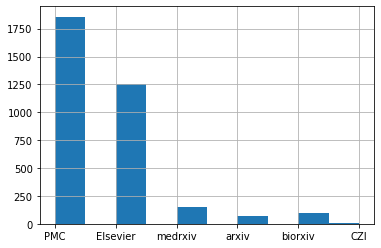

In [ ]:
print('Provenienza degli articoli')
df.source_x.hist();

Data di pubblicazione


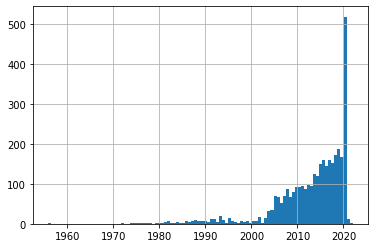

In [ ]:
print('Data di pubblicazione')
df.publish_time.hist(bins=100);

Giornale di pubblicazione


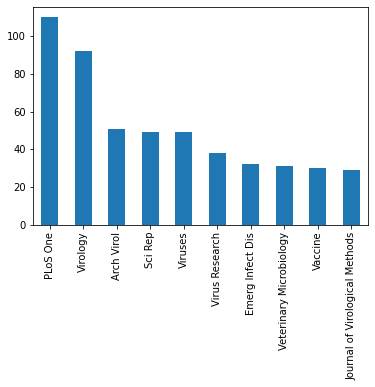

In [ ]:
print('Giornale di pubblicazione')
df.journal.value_counts().head(10).plot.bar();

Primi 20 autori per numero di pubblicazioni


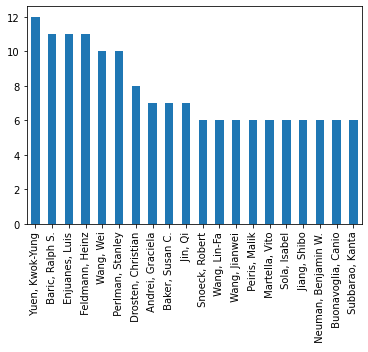

In [ ]:
print('Primi 20 autori per numero di pubblicazioni')
df.authors.str.split(';').explode().value_counts()[:20].plot.bar();

Articoli con full-text in formato pdf vs articoli con full-text xml


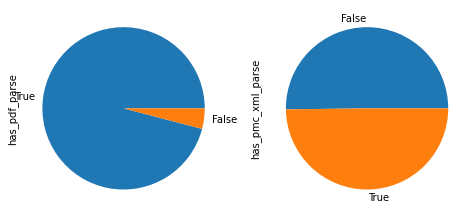

In [ ]:
print('Articoli con full-text in formato pdf vs articoli con full-text xml')
_, axes = plt.subplots(1, 2, figsize=(8,8))
df.has_pdf_parse.value_counts().plot.pie(subplots=True, ax=axes[0]);
df.has_pmc_xml_parse.value_counts().plot.pie(subplots=True, ax=axes[1]);

Licenze dei full-text


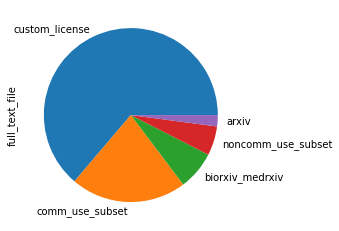

In [ ]:
print('Licenze dei full-text')
df.full_text_file.value_counts().plot.pie();

Analisi della lingua degli articoli.
* Il dataset contiene articoli in lingue diverse ma in larga misura la lingua più comune è l'inglese.
* Data la difficoltà nel lavorare con sistemi che supportano più lingue diverse, verranno scartati gli articoli che non sono in lingua inglese.

In [ ]:
!pip install langdetect;
from langdetect import detect
from langdetect import DetectorFactory

     |████████████████████████████████| 983kB 4.5MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=c66a6e7d4d550190f236326aa9ffab8e10f5b2324dfebb98358cb1e49018dfaf
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
# set seed
DetectorFactory.seed = 0

df['lang'] = 'en'
for ii in tqdm(range(0,len(df)), position=0, leave=True):
    text = df.iloc[ii]['abstract'].split(" ")
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            lang = "unknown"
            pass
    # get the language    
    df.loc[ii, 'lang'] = lang

Distribuzione lingua degli articoli


en    3387
fr      22
nl      11
es       8
de       5
ca       1
Name: lang, dtype: int64

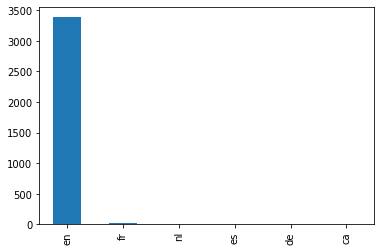

In [ ]:
print('Distribuzione lingua degli articoli')
df.lang.value_counts().plot.bar();
df.lang.value_counts()

In [ ]:
df = df[df.lang == 'en']
df.reset_index(drop=True, inplace=True)

## Processamento del testo
* Trasformazione del testo in minuscolo, rimozione di parole *stopwords* di inizio abstract, rimozione di sillabazione e punteggiatura.
* Rimozione di link, parole tra parentesi quadre, parole contenenti numeri e parole più corte di 3 caratteri.
* Per il preprocessing del testo viene usata la libreria SpaCy che tramite il modulo `scispacy` offre la possibilità di fare tokenizzazione e lemmatizzazione in maniera performante per documenti di carattere scientifico.


In [ ]:
!pip install scispacy;
!pip install 'https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_md-0.2.4.tar.gz'
import scispacy
import spacy
import en_core_sci_md

     |████████████████████████████████| 10.0MB 10.2MB/s 
     |████████████████████████████████| 71kB 2.2MB/s 
     |████████████████████████████████| 13.0MB 133kB/s 
     |████████████████████████████████| 2.1MB 28.5MB/s 
     |████████████████████████████████| 296kB 20.0MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 70.0MB 53kB/s 
  Created wheel for en-core-sci-md: filename=en_core_sci_md-0.2.4-cp36-none-any.whl size=70498246 sha256=5d0e587e8c5e3b9ed0d5b8f517fd27cb496a6228c276b4721f113809ad666c7e
  Stored in directory: /root/.cache/pip/wheels/12/b3/89/7fbb30f56411e8b4002eac6d5568ab46da63191a2287aa17bf
Successfully built en-core-sci-md


/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning:

[W031] Model 'en_core_sci_md' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate



In [ ]:
def clean_text(text):
    """ 
    Rende il testo minuscolo, elimina stopwords di inizio paragrafo,
    rimuove sillabazione e punteggiatura nella stringa @text.
    """
    text = text.lower()
    for w in ['abstract', 'background', 'introduction', 'article', 'summarize', 'title', 'objectives']:
      if text[:len(w)] == w:
          text = text[len(w):]
    text = re.sub(r'[%s]' % re.escape('--‐‑⁃−‒–—―'), '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    return text

In [ ]:
def spacy_lemmatizer(text):
    """Effettua la lemmatizzazione della stringa @text con SpaCy"""    
    return " ".join(
        [word.lemma_ for word in nlp(clean_text(text))
        if (word.lemma_ != '-PRON-')
        if not (word.like_num or word.is_stop or word.is_punct 
                or word.is_space or len(word)<=2 or word.like_url
                or word.like_email )
    ])

In [ ]:
nlp = en_core_sci_md.load()

/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning:

[W031] Model 'en_core_sci_md' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate



In [ ]:
tqdm.pandas(position=0, leave=True)
df['abstract_lemmatize'] = df['abstract'].progress_apply(spacy_lemmatizer)
df['title_lemmatize'] = df['title'].progress_apply(spacy_lemmatizer)

Si concatena il titolo di ogni articolo con il relativo abstract per ottenere il testo rappresentativo di ciascun articolo.

In [ ]:
df['merged'] = ((df['title_lemmatize'] + ' ') + df['abstract_lemmatize'])

In [ ]:
df['tokens'] = df['merged'].apply(lambda x: len(x.split()))

Statistiche sul numero di token nel testo (titolo + abstract) degli articoli.

In [ ]:
df['tokens'].describe()

count    3387.000000
mean      118.734278
std        47.136268
min         1.000000
25%        87.000000
50%       117.000000
75%       148.000000
max       634.000000
Name: tokens, dtype: float64

In [ ]:
df[['merged', 'tokens']].head(10)

,merged,tokens
0,integrate health national health policy develo...,219
1,evaluation sialic acid acutephase protein hapt...,162
2,enterovirus protease pro pro differentially in...,163
3,general strategy endow natural fusionproteinde...,144
4,epidemiology primary central nervous system tu...,147
5,induction cellcell fusion ebola virus glycopro...,173
6,pandemic avoid mistake body pile united state ...,23
7,mesenchymal stem cellderive extracellular vesi...,248
8,unknown,1
9,electronic datum interchange usage china healt...,83


### Rimozione articoli con testo non sufficientemente lungo
* Alcuni articoli possono avere a questo punto un testo (formato da titolo + abstract) non sufficientemente lungo per essere inclusi in un'analisi significativa.
* Si eliminano dal DataFrame tutti gli articoli con un numero di parole **distinte** inferiore a 5.

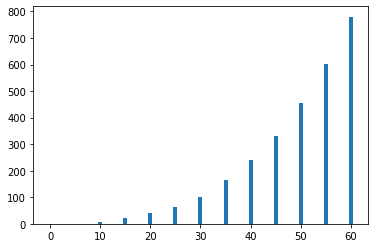

Articoli rimossi: 5


In [ ]:
df['unique_words'] = df['merged'].apply(lambda x:len(set(str(x).split())))
small_text = []
for i in tqdm(range(0,int(df.unique_words.quantile(.25)),5), position=0, leave=True):
    small_text.append((df['unique_words'] < i).sum())
plt.bar(list(range(0,int(df.unique_words.quantile(.25)),5)), small_text)
plt.show()
print('Articoli rimossi:', len(df[(df.unique_words < 10)]))
df = df[(df.unique_words >= 10)]
df.reset_index(inplace=True, drop=True)

## Analisi esplorativa sul dataset e sulle features derivate
* Viene eseguita l'analisi esplorativa su features derivate dal testo preprocessato per comprenderne le caratteristiche.


In [ ]:
if PLOT_STAT:
    fig = go.Figure( go.Histogram( x=df.merged.apply(lambda x: len(x.split())).iloc[:], nbinsx=100 ) )
    fig.update_layout(
      title='Distribuzione della lunghezza in parole degli articoli',
      xaxis_title="Lunghezza in parole dell'articolo",
      yaxis_title='Numero degli articoli',
    )
    fig.show()

In [ ]:
def get_top_n_grams(corpus, gram=1, n=None):
    """Restitisce i @n @gram-gram più frequenti nel @corpus."""
    vec = CountVectorizer(ngram_range=(gram, gram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
if PLOT_STAT:
    common_words = get_top_n_grams(df.merged, 1,20)
    df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
    fig = go.Figure( go.Bar( x=df2['unigram'], y=df2['count'] ) )
    fig.update_layout(
      title=('Top 20 unigram nel testo degli articoli dopo il preprocessing'),
      xaxis_title='Parole',
      yaxis_title='Frequenza',
    )
    fig.show()

In [ ]:
if PLOT_STAT:
    common_words = get_top_n_grams(df.merged, 2, 20)
    df2 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

    fig = go.Figure( go.Bar( x=df2['bigram'], y=df2['count'] ) )
    fig.update_layout(
      title=('Top 20 bigram nel testo degli articoli dopo il preprocessing'),
      xaxis_title='Parole',
      yaxis_title='Frequenza',
    )
    fig.show()

In [ ]:
if PLOT_STAT:    
    common_words = get_top_n_grams(df.merged, 3, 20)
    df2 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
    fig = go.Figure( go.Bar( x=df2['trigram'], y=df2['count'] ) )
    fig.update_layout(
      title=('Top 20 trigram nel testo degli articoli dopo il preprocessing'),
      xaxis_title='Parole',
      yaxis_title='Frequenza',
    )
    fig.show()

## Costruzione del vocabolario
* A partire dal corpus di articoli $d{_i}$ oggetto dell'analisi, si costruisce un vocabolario $D$ dei termini più significativi nel corpus (filtrati in base alla *document frequency*).


In [ ]:
def string_remove_stop(sentence, vocabulary):
    """
    Data una stringa @sentence e una lista @vocabulary restituisce una stringa 
    contenente solo le parole di @sentence che sono presenti anche in @vocabulary
    """
    return ' '.join([word for word in sentence.split() if word in vocabulary])

def list_remove_stop(sentence, vocabulary):
    """
    Data una stringa @sentence e una lista @vocabulary restituisce una lista 
    contenente solo le parole di @sentence che sono presenti anche in @vocabulary
    """
    return [word for word in sentence if word in vocabulary]

In [ ]:
def tokenizer(text):
    return str(nlp.tokenizer(text)).split()

Si costruisce il vocabolario di unigram dal corpus di articoli applicando un filtro sulle parole in base alla frequenza con cui appaiono negli articoli del corpus.

In [ ]:
vectorizer = CountVectorizer(min_df=10, max_df=.95, ngram_range=(1,1), tokenizer=tokenizer, token_pattern=None)
vectorizer.fit(df.merged)
print('Dimensione del vocabolario:', len(vectorizer.get_feature_names()))
vocabulary = vectorizer.get_feature_names()

Dimensione del vocabolario: 3468


Si ottiene una serie pandas che contiene per ogni articolo la lista dei soli token dell'articolo presenti nel vocabolario.

In [ ]:
tqdm.pandas(position=0, leave=True)
df['token_serie'] = df.merged.progress_apply(lambda x: list_remove_stop(x.split(), vocabulary))

Costruzione di un Dictionary gensim che verrà utilizzato nel seguito dell'analisi.

In [ ]:
dct = gensim.corpora.Dictionary(df['token_serie'])
corpus = [dct.doc2bow(s) for s in df['token_serie']]

## Ricerca con Elbow Method dei valori ottimali per il numero di topic nel corpus e per le componenti principali dello spazio dei termini.
* Si costruisce la *document-term matrix* (dtm) $X$ del corpus in base al vocabolario $D$ precedentemente costruito.
* Sia $X$ la matrice $|D|×|corpus|$ termini-documenti del corpus, allora $x{_{ij}}$ è il numero delle volte che il termine $w{_i}$ compare nel documento $d{_j}$. 
* $X$ viene poi pesato con schema tf-idf ottenendo $\tilde X$ e si riduce la sua dimensionalità con PCA, proiettando  $\tilde X$ in uno spazio in cui sia conservato il 70% della varianza per ridurre il rumore e rendere più veloce la computazione successiva.


Si calcola il valore ottimale per il numero di componenti principali dello spazio dei termini applicando la PCA sulla matrice $\tilde X$ e successivamente eseguendo la ricerca con Elbow Method.

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist

X = vectorizer.transform(df.merged)
X = TfidfTransformer(sublinear_tf=True).fit_transform(X)
pca = PCA(n_components=.7, random_state=42)
pca_c = pca.fit_transform(X.toarray().T)
print('Shape matrice parole x componenti:', pca_c.shape)

Shape matrice parole x componenti: (3468, 730)


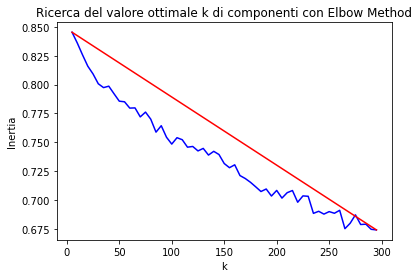

In [ ]:
inertia = []
K = list(range(5, 300, 5))
for k in tqdm(K, position=0, leave=True):
    k_means = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=5, init_size=1000, batch_size=1000, random_state=42)
    k_means.fit(pca_c)
    inertia.append(sum(np.min(cdist(pca_c, k_means.cluster_centers_, 'cosine'), axis=1)) / pca_c.shape[0])

plt.plot(K, inertia, 'b-')
plt.plot([K[0], K[-1]], [inertia[0], inertia[-1]], 'r')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Ricerca del valore ottimale k di componenti con Elbow Method')
plt.show()

* In base al grafico si sceglie 100 come valore ottimale per il numero di componenti principali dello spazio dei termini.

Si calcola il valore ottimale per i topic del corpus applicando la PCA sulla matrice $\tilde X{^T}$ e successivamente eseguendo la ricerca con Elbow Method.

In [ ]:
pca_c = pca.fit_transform(X.toarray())
print('Shape matrice documenti x componenti:', pca_c.shape)

Shape matrice documenti x componenti: (3382, 747)


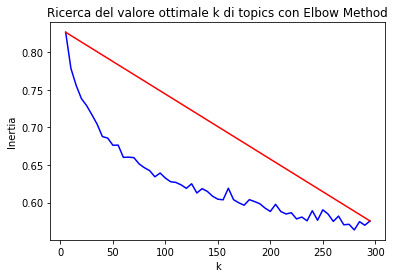

In [ ]:
inertia = []
K = list(range(5, 300, 5))
for k in tqdm(K, position=0, leave=True):
    k_means = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=5, init_size=1000, batch_size=1000, random_state=42)
    k_means.fit(pca_c)
    inertia.append(sum(np.min(cdist(pca_c, k_means.cluster_centers_, 'cosine'), axis=1)) / pca_c.shape[0])

plt.plot(K, inertia, 'b-')
plt.plot([K[0], K[-1]], [inertia[0], inertia[-1]], 'r')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Ricerca del valore ottimale k di topics con Elbow Method')
plt.show()

* In base al grafico si sceglie 80 come valore ottimale per il numero di topic.

## Implementazione modelli
* Sono implementati e si confrontano fra loro cinque modelli di learning, simili fra loro ma con performance differenti, per analizzare le relazioni tra gli articoli del corpus e i termini che contengono.
* Il risultato di questi modelli sarà uno spazio in cui possono essere rappresentati e confrontati fra loro gli articoli.

Si settano le costanti per il numero di componenti principali dello spazio dei termini e per il numero di topic in base ai valori calcolati precedentemente.
* `n_components` è il numero di componenti principali dello spazio dei termini.
* `n_topics` sono i topic più importanti del corpus di articoli
* `topn` è il numero di parole più rappresentative che saranno estratte per ogni topic.

In [ ]:
n_components = 100
n_topics = 80
topn = 10

Istanza di una classe che permette di pesare la matrice $X$ secondo lo schema tf-idf.

In [ ]:
transformer = TfidfTransformer(sublinear_tf=True)

In [ ]:
def voc_sim(word, mat, topn=10):
    """Calcola le @topn parole più simili a @word"""
    indx = vocabulary.index(word)
    if isinstance(mat, sparse.csr_matrix):
        v1 = mat.getrow(indx)
    else:
        v1 = mat[indx:indx+1, :]
    sims = cosine_similarity(mat, v1).flatten()
    sindxs = np.argsort(-sims)
    sim_word_scores = [(vocabulary[sindx], sims[sindx]) for sindx in sindxs[0:topn]]
    return sim_word_scores

In [ ]:
def print_top_words(components, feature_names, n_top_words=10):
    """Stampa le @n_top_words più rappresentative di un topic model"""
    for topic_idx, topic in enumerate(components):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
def tsne_plot(tsne_c, color=[], text=[], dim=2, fit=True):
    """
    Plot dei componenti della matrice numpy @tsne_c proiettati su @dim dimensioni 
    dall'algoritmo TSNE.
    """
    if fit:
        tsne_c = TSNE(dim, n_jobs=-1, perplexity=50, random_state=42).fit_transform(tsne_c)
    print('Data points:', len(tsne_c))
    xs = [w[0] for w in tsne_c]
    ys = [w[1] for w in tsne_c]
    fig = go.Figure()
    fig.add_scatter(x=xs, y=ys, mode='markers', marker=dict(color=color), text=text)
    fig.update_xaxes(title_text='First principal component')
    fig.update_yaxes(title_text='Second principal component')
    fig.show()

### Latent Semantic Analysis (LSA)
* Sia $\tilde X$ la matrice termini-documenti del corpus in cui $\tilde x{_{ij}} = f(x{_{ij}})$ con $f$ funzione di peso e $x{_{ij}}$ è il numero delle volte che l' $i$-esimo termine in $D$ compare nell'articolo $d{_j}$.
* Con SVD si ha $\tilde X = U*S*V{^T}$, dove $U$ è una matrice ortogonale che contiene i vettori singolari sinistri che corrispondono ai vettori dei termini, $V{^T}$ è una matrice ortogonale che contiene i vettori singolari destri che corrispondono ai vettori dei documenti e $S$ è una matrice diagonale che contiene i valori singolari di $\tilde X$.
* La LSA costruisce uno spazio semantico tramite SVD troncata a rango $t$: $\tilde X{_t} ≈ U{_t}*S{_t}*V{_t^T}$ dove $U{_t}$ è una matrice ortogonale $|D|×t$ contenente i vettori dei termini, $S{_t}$ è una matrice diagonale $t×t$ dei valori singolari e $V{_t^T}$ è una matrice ortogonale $t×|corpus|$ corrispondente ai vettori i documenti.

Si calcola la dtm pesata $\tilde X$ a partire da $X$ con schema tf-idf.

In [ ]:
X = vectorizer.transform(df.merged)
X = transformer.fit_transform(X)

In [ ]:
lsa = TruncatedSVD(n_components, algorithm='randomized', random_state=42)
lsa_c = lsa.fit_transform(X)

Per il modello LSA sia $\tilde X{_t} ≈ U{_t}*S{_t}*V{_t^T}$, si calcolano:
* `lsaU` = $U{_t}$
* `lsaS` = $S{_t}$
* `lsaVt` = $V{_t^T}$

In [ ]:
lsaU = lsa.components_.T
lsaS = lsa.singular_values_
lsaVt = np.linalg.inv(np.diag(lsa.singular_values_)) @ lsa_c.T

Word embedding dei termini estratto dal modello.

In [ ]:
lsa_vecs = normalize(lsaU @ np.diag(lsaS))

Esempio di parole più significative ad una parola data nello spazio dei termini.

In [ ]:
voc_sim('covid19', lsa_vecs)

[('covid19', 1.0000000000000002),
 ('covid', 0.8061114866484731),
 ('march', 0.7057816249620463),
 ('hubei', 0.6259515617299899),
 ('wuhan', 0.5990760157965046),
 ('february', 0.5957204260982436),
 ('quickly', 0.5907390911676154),
 ('lockdown', 0.5816563017009331),
 ('december', 0.5763353152457213),
 ('feb', 0.5695213884606417)]

Le prime `topn` parole con peso maggiore per ogni componente principale dello spazio dei termini.

In [ ]:
print_top_words(lsa_vecs.T, vocabulary)

Topic #0: result study include remain virus infection show determine addition present
Topic #1: march january diagnose hospital case implement february objective demographic record
Topic #2: detect aspirate nasopharyngeal pcr prospectively specimen rtpcr coinfection sample swab
Topic #3: sequence phylogenetic identity alignment nucleotide characterization recombination genome region ancestor
Topic #4: coronavirus syndrome sarscov severe cov sar spike receptorbinde nucleocapsid merscov
Topic #5: middle east merscov mer syndrome threat emergence sporadic emerge being
Topic #6: vaccinate elicit immunogenicity immunize titer immunization intramuscular heterologous antibody protection
Topic #7: specificity sensitivity assay analytical pointofcare conventional reagent kit multiplexed optical
Topic #8: h3n2 influenza iav neuraminidase seasonal h1n1 wave pandemic timedependent virus
Topic #9: liveattenuated license neuraminidase vaccine influenza efficacy safe immunogenicity vaccination hemagg

Creazione e output testuale della lista delle prime `topn` parole più significative per ogni topic.
* Viene applicato il clustering K-Means con `n_topics` centroidi sui vettori di embedding dei termini normalizzati.

In [ ]:
lsa_km = KMeans(n_topics, random_state=42)
lsa_kmv = lsa_km.fit_transform(normalize(lsa_vecs))
lsa_original_space_centroids = lsa_km.cluster_centers_ @ normalize(lsa_vecs).T
lsa_order_centroids = lsa_original_space_centroids.argsort()[:, ::-1]
lsa_terms = vocabulary
lsa_topics = []
for i in range(lsa_km.n_clusters):
    print("Cluster %d:" % i, end='')
    words = []
    for ind in lsa_order_centroids[i, :topn]:
        words.append(lsa_terms[ind])
        print(' %s' % lsa_terms[ind], end='')
    lsa_topics.append(words)
    print()

Cluster 0: approve drug therapeutic promising potential currently fda effective option candidate
Cluster 1: west ebola africa african evd filovirus ebov gathering nile hemorrhagic
Cluster 2: contrast mutant demonstrate phenotype wildtype interestingly lack cell mutation kinetic
Cluster 3: achieve improve need necessary use cost require successful efficient rely
Cluster 4: significantly decrease increase observe reduce result follow investigate show reduction
Cluster 5: policy political poverty government community financial crisis policymaker service relation
Cluster 6: equation numerical mathematical compartmental sir dynamic ordinary model nonlinear parameter
Cluster 7: express recombinant generate engineer protein native chimeric insect baculovirus retain
Cluster 8: transplantation transplant recipient hematopoietic allogeneic graft immunosuppression hsct malignancy donor
Cluster 9: nidovirale rna coronaviridae rnadependent rdrp positivesense singlestrande stranded family member
Clu

Implementazione della funzione di query per il modello ed esecuzione di una query di test.

In [ ]:
def lsa_query(query, topn=10):
    query = spacy_lemmatizer(query)
    query2vec = vectorizer.transform([query])
    query2vec = (query2vec @ lsaU) @ np.linalg.inv(np.diag(lsaS))
    sims = np.array([cosine_distances(query2vec, [lsaVt.T[j]])[0][0] for j in tqdm(range(int(len(lsaVt.T))), position=0, leave=True)])
    sindxs = np.argsort(sims)
    sim_scores = np.array([(sindx, sims[sindx]) for sindx in sindxs[0:topn]])
    ret = pd.DataFrame(df.iloc[sim_scores[:, 0]])
    ret['scores'] = sim_scores[:, 1]
    return ret[['title', 'abstract', 'publish_time', 'authors', 'scores']]

In [ ]:
query = 'nasal swab pcr virus covid-19'

In [ ]:
lsa_query(query)

,title,abstract,publish_time,authors,scores
1398,Estimation of population infected by Covid-19 ...,"In this work, a proposal for the estimation of...",2020-04-02,Mario Villalobos-Arias,0.479409
2427,Comparison of four nasal sampling methods for ...,Abstract The aim of this study was to compare ...,2009-03-31,"Spyridaki, Irini S.; Christodoulou, Ioannis; d...",0.534251
2808,Covid-19 pandemic and the skin - What should d...,Abstract The World has changed dramatically si...,2020-03-24,"Darlenski, Razvigor; Tsankov, Nikolai",0.547462
1480,Misdiagnosis in the COVID era: When Zebras are...,Abstract We report a patient who presented wit...,2020-04-27,"Yousefzai, Rayan; Bhimaraj, Arvind",0.552075
3245,Rapid Detection of Novel Coronavirus (COVID-19...,Novel Corona virus (COVID-19 or 2019-nCoV) is ...,2020-02-24,Laura E Lamb; Sarah N Bartolone; Elijah Ward; ...,0.569140
2582,Swabbing for respiratory viral infections in o...,The purpose of this study was to compare the s...,2010-09-18,"Hernes, S. S.; Quarsten, H.; Hagen, E.; Lyngro...",0.577704
300,"In states with prominent virus crisis, door wi...",Amid ever‐changing policy developments in resp...,2020-04-03,"Enos, Gary",0.603758
522,A case of COVID-19 and pneumonia returning fro...,Abstract A 46-year-old woman presented to the ...,2020-03-10,"Lee, Nan-Yao; Li, Chia-Wen; Tsai, Huey-Pin; Ch...",0.607682
483,Home Self-Collection of Nasal Swabs for Diagno...,BACKGROUND: Understanding the importance of re...,2013-07-14,"Emerson, Julia; Cochrane, Elizabeth; McNamara,...",0.624273
2970,A possible role for B cells in COVID-19?: Less...,Summary COVID-19 had a mild clinical course in...,2020-04-22,"Quinti, Isabella; Lougaris, Vassilios; Milito,...",0.638970


Grafico dello spazio delle parole dopo aver applicato una riduzione della dimensionalità a due dimensioni con algoritmo TSNE.

In [ ]:
tsne_plot(lsa_vecs, lsa_km.labels_, lsa_terms)

Data points: 3468


### Probabilistic Latent Semantic Analysis (pLSA)
* Estensione probabilistica della LSA.
* Per implementare il modello pLSA attraverso NMF si utilizza una versione normalizzata $\bar X$ della matrice termini-documenti in cui $\bar x{_{ij}} = P(w{_i}|d{_j})$.
* Dal modello $P(w{_i}|d{_j}) = \sum{_k} P(w{_i}|z{_k})P(z{_k}|d{_j})$
* La matrice $\bar X$ viene fattorizzata in due matrici tali che $\bar X ≈ W * H$: la matrice $|D|×t$ $W$ con $W>=0$ e la matrice $t×|corpus|$ $H$ con $H>=0$.

Calcolo di  $\bar X$ con $\bar x{_{ij}} = P(w{_i}|d{_j})$.

In [ ]:
X = vectorizer.transform(df.merged)
X = TfidfTransformer(sublinear_tf=True, use_idf=False, norm='l1').fit_transform(X)

Costruzione del modello NonnegativeMatrixFactorization e fit ai dati.

In [ ]:
nmf = NMF(n_components, solver='mu', max_iter=1000, beta_loss=1, random_state=42)
nmf.fit(X)

NMF(alpha=0.0, beta_loss=1, init=None, l1_ratio=0.0, max_iter=1000,
    n_components=100, random_state=42, shuffle=False, solver='mu', tol=0.0001,
    verbose=0)

Dal modello NMF sia $\bar X ≈ W * H$, con $w{_{ik}} = P(w{_i}|z{_k})$ e $h{_{kj}} = P(z{_k}|d{_j})$.
* `nmf_dnorm` è la matrice $H$ dopo essere stata normalizzata con norma l1 per colonne.
* `nmf_components` è la matrice $W$ dopo essere stata normalizzata con norma l1 per righe.

In [ ]:
nmf_c = nmf.transform(X)
dmult = np.diag(nmf_c.sum(axis=1))
nmf_dnorm = np.linalg.inv(dmult) @ nmf_c

In [ ]:
wmult = np.diag(nmf.components_.sum(axis=1))
nmf_components = nmf.components_.T @ np.linalg.inv(wmult)

Esempio di parole più significative ad una parola data nello spazio dei termini.

In [ ]:
voc_sim('covid19', nmf_components)

[('covid19', 0.9999999999999998),
 ('hubei', 0.9846658622996227),
 ('lockdown', 0.9265996236623426),
 ('feb', 0.903520819279225),
 ('forecast', 0.9008781392944114),
 ('seir', 0.8985346814676186),
 ('jan', 0.8825236260743903),
 ('sir', 0.8704375067444718),
 ('february', 0.8452468362955005),
 ('distancing', 0.8148676046924124)]

Le prime `topn` parole con peso maggiore per ogni componente principale dello spazio dei termini.

In [ ]:
print_top_words(nmf_components.T, vocabulary)

Topic #0: infection virus viral disease cause study infect human infected pathogenesis
Topic #1: cell protein virus replication viral expression cellular host express demonstrate
Topic #2: respiratory virus patient clinical detect infection tract viral child sample
Topic #3: sequence analysis strain gene isolate genome study phylogenetic sample molecular
Topic #4: virus human genome viral animal sequence evolution host genetic disease
Topic #5: coronavirus respiratory syndrome merscov middle east severe acute mer case
Topic #6: covid19 model case number sarscov2 pandemic estimate outbreak coronavirus country
Topic #7: protein viral cellular function virus host process target interaction review
Topic #8: assay virus detection rapid test specificity develop sensitivity sample development
Topic #9: patient clinical disease covid19 case day severe outcome characteristic hospital
Topic #10: activity antiviral drug compound human inhibitor virus study novel potential
Topic #11: health public

Creazione e output testuale della lista delle prime `topn` parole più significative per ogni topic.
* Viene applicato il clustering K-Means con `n_topics` centroidi sui vettori di embedding dei termini normalizzati.

In [ ]:
nmf_km = KMeans(n_topics, random_state=42)
nmf_kmv = nmf_km.fit_transform(normalize(nmf_components))
nmf_original_space_centroids = nmf.inverse_transform(nmf_km.cluster_centers_)
nmf_order_centroids = nmf_original_space_centroids.argsort()[:, ::-1]
nmf_sorted_centroids = nmf_order_centroids.argsort()
labels = {t: nmf_sorted_centroids[:, ij].argmin() for ij, t in enumerate(vocabulary)}
nmf_terms = vocabulary
nmf_topics = []
for i in range(nmf_km.n_clusters):
    words = []
    print("Cluster %d:" % i, end='')
    for ind in nmf_order_centroids[i, :topn]:
        words.append(nmf_terms[ind])
        print(' %s' % nmf_terms[ind], end='')
    nmf_topics.append(words)
    print()

Cluster 0: cause study identify review state clinical number potential remain infectious
Cluster 1: control epidemic outbreak transmission prevention measure case contact korea south
Cluster 2: gene expression chapter human include profile genetic history different introduction
Cluster 3: cat feline animal domestic case peritonitis use diagnostic veterinary fip
Cluster 4: cell agent mouse respiratory cause expression strain development acute study
Cluster 5: management emergency care medical hospital study control patient problem high
Cluster 6: require base set use allow present identify novel achieve disease
Cluster 7: novel coronavirus feature 2019ncov pneumonia study lesion predict provide patient
Cluster 8: protein antibody vaccine recombinant neutralize serum human antigen monoclonal express
Cluster 9: analysis enzyme base provide ace2 type analyze system codon angiotensin
Cluster 10: provide information management high method important paper disease study health
Cluster 11: acti

Implementazione della funzione di query per il modello ed esecuzione di una query di test.

In [ ]:
query = 'nasal swab pcr virus covid-19'

In [ ]:
from scipy.stats import entropy
def plsa_query(query, topn=10):
    query = spacy_lemmatizer(query)
    query2vec = vectorizer.transform([query])
    query2vec = nmf.transform(query2vec)
    query2vec = normalize(query2vec, norm='l1')
    sims = np.array([entropy(query2vec.squeeze(), nmf_dnorm[j]) for j in tqdm(range(int(len(nmf_dnorm))), position=0, leave=True)])
    sindxs = np.argsort(sims)
    sim_scores = np.array([(sindx, sims[sindx]) for sindx in sindxs[0:topn]])
    ret = pd.DataFrame(df.iloc[sim_scores[:, 0]])
    ret['scores'] = sim_scores[:, 1]
    return ret[['title', 'abstract', 'publish_time', 'authors', 'scores']]

In [ ]:
plsa_query(query)

,title,abstract,publish_time,authors,scores
1684,Infections and coinfections by respiratory hum...,The human bocavirus (hBoV) has been identified...,2016-05-06,"Calvo, Cristina; García‐García, María Luz; Poz...",0.978368
2015,Epidemiological parameter review and comparati...,Influenza-like illness (ILI) accounts for a la...,2020-02-05,Julie Spencer; Deborah P Shutt; Sarah K Moser;...,1.170394
361,Duration of quarantine in hospitalized patient...,In December 2019 a new form of pneumonia was o...,2020-03-06,"Lombardi, Andrea; Bozzi, Giorgio; Mangioni, Da...",1.463697
83,Ophthalmologic evidence against the interperso...,Background: The emerging 2019 novel coronaviru...,2020-02-12,Yunyun Zhou; Yuyang Zeng; Yongqing Tong; Chang...,1.675434
922,Clinical significance of respiratory virus det...,Abstract Background The impact of viral infect...,2018-03-31,"Saraya, Takeshi; Kimura, Hirokazu; Kurai, Dais...",1.788246
1176,Respiratory viral infections in institutions f...,Please cite this paper as: Asner et al. (2012)...,2012-02-21,"Asner, Sandra; Peci, Adriana; Marchand‐Austin,...",1.815884
175,Exploration of the Effectiveness of Social Dis...,Background. In both military and civilian sett...,2008-11-15,"Broderick, Michael P.; Hansen, Christian J.; R...",1.852659
3216,Sore Throat,Approximately 12 million patients present with...,2017-09-14,"Ciuffo, Lori",1.886191
1847,Middle East respiratory syndrome coronavirus (...,Abstract Background Middle East respiratory sy...,2020-04-30,"Farooq, Hamzah Z.; Davies, Emma; Ahmad, Shazaa...",1.932431
890,Mobile and accurate detection system for infec...,The 2009 pandemic H1N1 influenza A virus sprea...,2011-02-15,"Hatano, Ben; Goto, Megumi; Fukumoto, Hitomi; O...",1.999795


Grafico dello spazio delle parole dopo aver applicato una riduzione della dimensionalità a due dimensioni con algoritmo TSNE.

In [ ]:
tsne_plot(nmf_components, color=list(labels.values()), text=nmf_terms)

Data points: 3468


### Word Embedding con SVD e PMI (modello PMI-SVD)
* Si implementa il modello di word embedding proposto in:
> [Levy et al.2015] Omer Levy, Yoav Goldberg, and Ido
Dagan. 2015. Improving distributional similarity with
lessons learned from word embeddings. TACL.
* Questo modello prevede che sia costruita una matrice quadrata delle co-occorrenze termine-termine.
* A partire dalla matrice delle co-occorrenze tra parole è possibile ottenere con un opportuno schema di peso la matrice $PMI$ di dimensione $|D|$×$|D|$ dal corpus.
Ogni cella della matrice $pmi{_{ij}}$ contiene un valore proporzionale alla mutua informazione punto-punto tra il termine $w{_i}$ e il termine di contesto $w{_j}$.
* L'embedding dei termini in uno spazio semantico a ridotta dimensionalità si ottiene con la SVD sulla matrice $PMI$ troncata ad un rango $t < rank(PMI))$.
* Si noti che secondo O. Levy and Y. Goldberg. (2014), questo algoritmo è concettualemente equivalente a Word2vec nella variante *skip-gram with negative-sampling* (SGNS):
> [Levy et al.2014] O. Levy and Y. Goldberg. Neural word embedding as
implicit matrix factorization. In Advances in Neural
Information Processing Systems, pages 2177–2185, 2014.

Costruzione del dizionario degli unigram, viene assegnato un ID unico a ciascun token, viene memorizzato il mapping in due dizionari (`tok2indx` and `indx2tok`) e si conta quante volte ciascun termine appare nel corpus.

In [ ]:
unigram_counts = Counter()
for idx, abstract in enumerate(tqdm(df['token_serie'], position=0, leave=True)): 
    for token in abstract:
        unigram_counts[token] += 1
tok2idx = {tok: idx for idx, tok in enumerate(unigram_counts.keys())}
idx2tok = {idx: tok for tok,idx in tok2idx.items()}

print('Vocabulary size: {}'.format(len(unigram_counts)))
tok2list = list(tok2idx.keys())
assert [w for w in vocabulary if w not in tok2list] == []


Vocabulary size: 3468


Costruzione dizionario dei bigram. Si scorre con una finestra su ogni parola del testo di ciascun articolo (context words) e si formano i cosidetti *skipgram* esaminando le parole all'interno della finestra.

In [ ]:
back_window = 4
front_window = 4
skipgram_counts = Counter()
for iheadline, headline in enumerate(tqdm(df['token_serie'], position=0, leave=True)):
    tokens = [tok2idx[tok] for tok in headline]
    for ii_word, word in enumerate(tokens):
        ii_context_min = max(0, ii_word - back_window)
        ii_context_max = min(len(headline) - 1, ii_word + front_window)
        ii_contexts = [
            ii for ii in range(ii_context_min, ii_context_max + 1) 
            if (ii != ii_word and tokens[ii_word] != tokens[ii])]
        for ii_context in ii_contexts:
            skipgram = (tokens[ii_word], tokens[ii_context])
            skipgram_counts[skipgram] += 1    
        
print('Number of skipgrams: {}'.format(len(skipgram_counts)))


Number of skipgrams: 1103266


Si costruisce la matrice delle co-occorrenze termine-termine.

In [ ]:
row_indxs = []
col_indxs = []
dat_values = []
for (tok1, tok2), sg_count in tqdm(skipgram_counts.items(), position=0, leave=True):
    row_indxs.append(tok1)
    col_indxs.append(tok2)
    dat_values.append(sg_count)
wwcnt_mat = sparse.csr_matrix((dat_values, (row_indxs, col_indxs)))

In [ ]:
def ww_sim(word, mat, topn=10):
    """Calcola le @topn parole più simili a @word secondo i vettori in @mat"""
    indx = tok2idx[word]
    if isinstance(mat, sparse.csr_matrix):
        v1 = mat.getrow(indx)
    else:
        v1 = mat[indx:indx+1, :]
    sims = cosine_similarity(mat, v1).flatten()
    sindxs = np.argsort(-sims)
    sim_word_scores = [(idx2tok[sindx], sims[sindx]) for sindx in sindxs[0:topn]]
    return sim_word_scores

In [ ]:
def wout_sim(word, mat1, mat2, topn=10):
    """Calcola le @topn parole più simili a @word secondo i vettori in @mat1 e @mat2"""
    indx = tok2idx[word]
    if isinstance(mat1, sparse.csr_matrix):
        v1 = mat1.getrow(indx)
    else:
        v1 = mat1[indx:indx+1, :]
    sims = cosine_similarity(mat2, v1).flatten()
    sindxs = np.argsort(-sims)
    sim_word_scores = [(idx2tok[sindx], sims[sindx]) for sindx in sindxs[0:topn]]
    return sim_word_scores

Esempio di similarità tra parole a partire dalla matrice delle co-occorenze di termini.

In [ ]:
ww_sim('covid19', wwcnt_mat)

[('covid19', 0.9999999999999686),
 ('report', 0.7041638905842321),
 ('hospital', 0.6879369520840172),
 ('china', 0.6877120156644856),
 ('experience', 0.6756228802498943),
 ('outbreak', 0.6738926626947539),
 ('suspect', 0.6737409879804219),
 ('pneumonia', 0.6711414867134686),
 ('case', 0.6697670332707023),
 ('2019ncov', 0.6509566293279408)]

Calcolo della mutua informazione punto-punto (PMI) per una coppia (word, context) nel corpus, definita come la probabilità della loro co-occorrenza divisa per la probabilità che appaiano indipendentemente:
$pmi(w,c)=log(\frac {p(w,c)} {p(w)p(c)})$.
 
In oltre si può definire la mutua informazione punto-punto positiva (PPMI) come: $ppmi(w,c)=max[pmi(w,c),0]$
 
Una possibilità è anche applicare un fattore di smoothing al denominatore della formula della PMI, per mitigare il peso di coppie (word, context) rare.

In [ ]:
num_skipgrams = wwcnt_mat.sum()
assert(sum(skipgram_counts.values())==num_skipgrams)

k = 1

# for creating sparse matrices
row_indxs = []
col_indxs = []

pmi_dat_values = []    # pointwise mutual information
ppmi_dat_values = []   # positive pointwise mutial information
spmi_dat_values = []   # smoothed pointwise mutual information
sppmi_dat_values = []  # smoothed positive pointwise mutual information

# sum_over_rows[ii] = sum_over_words[ii] = wwcnt_mat.getcol(ii).sum()
sum_over_words = np.array(wwcnt_mat.sum(axis=0)).flatten()
# sum_over_cols[ii] = sum_over_contexts[ii] = wwcnt_mat.getrow(ii).sum()
sum_over_contexts = np.array(wwcnt_mat.sum(axis=1)).flatten()

# smoothing
alpha = .75
sum_over_words_alpha = sum_over_words**alpha
nca_denom = np.sum(sum_over_words_alpha)

for (tok_word, tok_context), sg_count in tqdm(skipgram_counts.items(), position=0, leave=True):

    nwc = sg_count
    Pwc = nwc / num_skipgrams
    nw = sum_over_contexts[tok_word]
    Pw = nw / num_skipgrams
    nc = sum_over_words[tok_context]
    Pc = nc / num_skipgrams
    nca = sum_over_words_alpha[tok_context]
    Pca = nca / nca_denom
    
    pmi = np.log2(Pwc/(Pw*Pc)) - np.log2(k)
    ppmi = max(pmi, 0)
    spmi = np.log2(Pwc/(Pw*Pca)) - np.log2(k)
    sppmi = max(spmi, 0)
    
    row_indxs.append(tok_word)
    col_indxs.append(tok_context)
    pmi_dat_values.append(pmi)
    ppmi_dat_values.append(ppmi)
    spmi_dat_values.append(spmi)
    sppmi_dat_values.append(sppmi)

pmi_mat = sparse.csr_matrix((pmi_dat_values, (row_indxs, col_indxs)))
ppmi_mat = sparse.csr_matrix((ppmi_dat_values, (row_indxs, col_indxs)))
spmi_mat = sparse.csr_matrix((spmi_dat_values, (row_indxs, col_indxs)))
sppmi_mat = sparse.csr_matrix((sppmi_dat_values, (row_indxs, col_indxs)))

Si normalizza la matrice delle co-occorenze pesata con PMI prima di essere ridotta di dimensionalità con SVD.

In [ ]:
use_mat = normalize(sppmi_mat, norm='l2', axis=0)

In [ ]:
svd = TruncatedSVD(n_components, algorithm='randomized', random_state=42)
svd_c = svd.fit_transform(use_mat.T)

Per il modello SVD sia $ PMI{_t} ≈ U{_t}*S{_t}*V{_t^T}$, si calcolano:
* `lsaU` = $U{_t}$
* `lsaS` = $S{_t}$
* `lsaVt` = $V{_t^T}$
* In questo caso sia $U{_t}$ che $V{_t^T}$ rappresentano un appropriato word embedding, la scelta del migliore può essere effettuata su base empirica.

In [ ]:
svdU = svd.components_.T
svdS = svd.singular_values_
svdVt = np.linalg.inv(np.diag(svd.singular_values_)) @ svd_c.T

Word embedding dei termini estratto dal modello.

In [ ]:
wvecs = normalize(svdU @ np.diag(svdS))

Esempio di parole più significative ad una parola data nello spazio dei termini.

In [ ]:
ww_sim('covid19', wvecs)

[('covid19', 1.0),
 ('wuhan', 0.7991552381084367),
 ('outbreak', 0.7806388962563069),
 ('case', 0.7724782666077037),
 ('report', 0.7665027803868081),
 ('february', 0.7482664648853761),
 ('march', 0.7448752851240281),
 ('december', 0.7445243899576495),
 ('epidemic', 0.7441540496593904),
 ('china', 0.7406096938302504)]

Le prime `topn` parole con peso maggiore per ogni componente principale dello spazio dei termini.

In [ ]:
print_top_words(wvecs.T, list(tok2idx.keys()))

Topic #0: different possible particular result include find present indicate determine describe
Topic #1: protein express inhibit expression activate cell mediate constitutively induce activation
Topic #2: patient hospitalize child day 1year sign age month infant die
Topic #3: phylogenetic sequence rtpcr pcr nested vp2 primer nucleotide analysis sample
Topic #4: assay qpcr rtqpcr test method isothermal quantitative sensitivity technique qrtpcr
Topic #5: vaccine enteric agent animal swine lethal reemerging heterologous infectious rotavirus
Topic #6: pneumonia asthma bronchiolitis etiology common clinical wheezing otitis obstructive communityacquired
Topic #7: assumption temporal parameter estimation compartmental spatial branching variance sir stochastic
Topic #8: il8 transcription cytokine upregulation proinflammatory chemokine upregulate rtpcr inhouse qpcr
Topic #9: comprehensively modality randomized etiological cognate syndromeassociate chance fight landscape altogether
Topic #10: c

Creazione e output testuale della lista delle prime `topn` parole più significative per ogni topic.
* Viene applicato il clustering K-Means con `n_topics` centroidi sui vettori di embedding dei termini normalizzati.

In [ ]:
svd_km = KMeans(n_topics, random_state=42)
svd_kmv = svd_km.fit_transform(normalize(wvecs))
svd_original_space_centroids = svd_km.cluster_centers_ @ normalize(wvecs).T
svd_order_centroids = svd_original_space_centroids.argsort()[:, ::-1]
svd_terms = list(tok2idx.keys())
svd_topics = []
for i in range(svd_km.n_clusters):
    words = []
    print("Cluster %d:" % i, end='')
    for ind in svd_order_centroids[i, :topn]:
        words.append(svd_terms[ind])
        print(' %s' % svd_terms[ind], end='')
    svd_topics.append(words)
    print()

Cluster 0: comprehensively result discrepancy desirable inconsistent interpret independently concurrent inclusion occurrence
Cluster 1: different possible investigate find present include individual describe consider evidence
Cluster 2: chance insufficient prevent compromise necessary clear setting prioritize considerable possible
Cluster 3: january december march china february october demographic case city report
Cluster 4: sequence nucleotide genome segment region single conserve gene terminal cdna
Cluster 5: cn demyelination nervous sclerosis brain inflammatory demyelinating macrophage infiltration chemokine
Cluster 6: different existence respect similar find indicate variation minor known contrast
Cluster 7: course suspect patient outcome intensive admission icu discharge diagnose complication
Cluster 8: promising therapeutic development candidate delivery vaccine safe potential effective rational
Cluster 9: symptom fatigue cough uncommon vomiting vomit manifestation onset fever s

Rappresentazione degli articoli del corpus nel nuovo spazio semantico come somma dei vettori dei termini che li compongono.

In [ ]:
svd2vecs = np.stack(df['token_serie'].apply(lambda x: (1/len(x))*np.sum([wvecs[tok2idx[t]] for t in x], axis=0)))

Implementazione della funzione di query per il modello ed esecuzione di una query di test.

In [ ]:
def svdpmi_query(query, topn=10):
    query = spacy_lemmatizer(query).split()
    query2vec = (1/len(query))*np.sum([wvecs[tok2idx[t]] for t in query if t in svd_terms], axis=0)
    sims = np.array([cosine_distances([query2vec], [svd2vecs[j]])[0][0] for j in tqdm(range(int(len(svd2vecs))), position=0, leave=True)])
    sindxs = np.argsort(sims)
    sim_scores = np.array([(sindx, sims[sindx]) for sindx in sindxs[0:topn]])
    ret = pd.DataFrame(df.iloc[sim_scores[:, 0]])
    ret['scores'] = sim_scores[:, 1]
    return ret[['title', 'abstract', 'publish_time', 'authors', 'scores']]

In [ ]:
query = 'nasal swab pcr virus covid-19'

In [ ]:
svdpmi_query(query)

,title,abstract,publish_time,authors,scores
2427,Comparison of four nasal sampling methods for ...,Abstract The aim of this study was to compare ...,2009-03-31,"Spyridaki, Irini S.; Christodoulou, Ioannis; d...",0.097015
2582,Swabbing for respiratory viral infections in o...,The purpose of this study was to compare the s...,2010-09-18,"Hernes, S. S.; Quarsten, H.; Hagen, E.; Lyngro...",0.097476
228,Application and optimization of RT-PCR in diag...,Background: Coronavirus Disease 2019 (COVID-19...,2020-02-27,Guanmin Jiang; Xiaoshuai Ren; Yan Liu; Hongtao...,0.120276
483,Home Self-Collection of Nasal Swabs for Diagno...,BACKGROUND: Understanding the importance of re...,2013-07-14,"Emerson, Julia; Cochrane, Elizabeth; McNamara,...",0.132894
1238,Detection of Respiratory Viruses from ARTI Pat...,INTRODUCTION: Acute respiratory tract infectio...,2017-01-01,"Kuan, Chee Sian; Yew, Su Mei; Hooi, Poh Sim; L...",0.138764
741,Detection of respiratory pathogens by real-tim...,The use of a multiplex respiratory real-time P...,2006-12-20,"van Kruijssen, Alida M.; Templeton, Kate E.; v...",0.139673
198,Viral respiratory infections diagnosed by mult...,Syndromic diagnosis by multiplex nucleic acid ...,2019-01-03,"Appak, Özgür; Duman, Murat; Belet, Nurşen; Say...",0.140742
145,Two RT-PCR based assays to detect human metapn...,Abstract Two sensitive and specific RT-PCR ass...,2005-10-31,"López-Huertas, María Rosa; Casas, Inmaculada; ...",0.141310
571,A multiplex liquid-chip assay based on Luminex...,We utilized one-step multiplex reverse transcr...,2017-06-17,"Yan, Yong; Luo, Jian-Yong; Chen, Yin; Wang, He...",0.143219
2008,Identification of New Pathogens in the Intraoc...,Purpose To determine infectious causes in pati...,2010-11-30,"de Groot-Mijnes, Jolanda D.F.; de Visser, Lenn...",0.144271


Grafico dello spazio delle parole dopo aver applicato una riduzione della dimensionalità a due dimensioni con algoritmo TSNE.

In [ ]:
tsne_plot(wvecs, svd_km.labels_, svd_terms)

Data points: 3468


### Ensembling LSA e PMI-SVD
* Si costruisce un modello di learning ensemble combinando il modello LSA con il modello costruito con la SVD sulla matrice PMI delle co-occorenze fra termini.
* La costruzione del modello consiste semplicemente nel concatenare i vettori dei termini del modello LSA con quelli del modello PMI-SVD per ottenere word embeddings che possano sfruttare e racchiudere i benefici sia di un modello che dell'altro.

Confronto tra i valori singolari dei vettori dei termini del modello LSA e PMI-SVD.

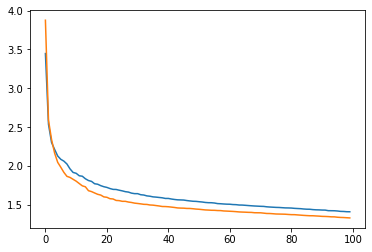

In [ ]:
plt.plot(lsaS**.5);
plt.plot(svdS**.5);

Word embedding dei termini estratto dal modello.

In [ ]:
ens_wv = np.stack(pd.Series([np.hstack((wvecs[tok2idx[t]], lsa_vecs[vocabulary.index(t)])) for t in tok2idx.keys()], index=tok2idx.keys()))

Rappresentazione degli articoli del corpus nel nuovo spazio semantico come somma dei vettori dei termini che li compongono.

In [ ]:
doc2vecs = np.stack(df['token_serie'].apply(lambda x: (1/len(x))*np.sum([ens_wv[tok2idx[t]] for t in x], axis=0)))

Creazione e output testuale della lista delle prime `topn` parole più significative per ogni topic.
* Viene applicato il clustering K-Means con `n_topics` centroidi sui vettori di embedding dei termini normalizzati.

In [ ]:
ens_km = KMeans(n_topics, random_state=42)
ens_kmv = ens_km.fit_transform(normalize(ens_wv))
ens_original_space_centroids = ens_km.cluster_centers_ @ normalize(ens_wv).T
ens_order_centroids = ens_original_space_centroids.argsort()[:, ::-1]
ens_terms = list(tok2idx.keys())
ens_topics = []
for i in range(ens_km.n_clusters):
    print("Cluster %d:" % i, end='')
    words = []
    for ind in ens_order_centroids[i, :topn]:
        words.append(ens_terms[ind])
        print(' %s' % ens_terms[ind], end='')
    ens_topics.append(words)
    print()

Cluster 0: animal wild domestic livestock ruminant wildlife veterinary pet exotic being
Cluster 1: fluorescence energy transfer reporter single kinetic dye employ label resonance
Cluster 2: electrophoresis purify gel chromatography spectrometry purification yeast band correspond mass
Cluster 3: certain think possible suggest link fact despite appear particular depend
Cluster 4: health national international public agency collaboration preparedness authority priority organization
Cluster 5: possible include remain suggest important major different present find know
Cluster 6: vitro inhibit inhibition dosedependent manner a549 demonstrate cell cytopathic effect
Cluster 7: apply algorithm tool prediction computational stateoftheart predict approach deep accuracy
Cluster 8: season ili winter influenzalike year incidence aged ari september illness
Cluster 9: cytokine il6 elevated il10 ifnγ mononuclear level monocyte proinflammatory chemokine
Cluster 10: mutant deletion mutation wildtype pas

Implementazione della funzione di query per il modello ed esecuzione di una query di test.

In [ ]:
def lsapmi_query(query, topn=10):
    query = spacy_lemmatizer(query).split()
    query2vec = (1/len(query))*np.sum([ens_wv[tok2idx[t]] for t in query if t in ens_terms], axis=0)
    sims = np.array([cosine_distances([query2vec], [doc2vecs[j]])[0][0] for j in tqdm(range(int(len(doc2vecs))), position=0, leave=True)])
    sindxs = np.argsort(sims)
    sim_scores = np.array([(sindx, sims[sindx]) for sindx in sindxs[0:topn]])
    ret = pd.DataFrame(df.iloc[sim_scores[:, 0]])
    ret['scores'] = sim_scores[:, 1]
    return ret[['title', 'abstract', 'publish_time', 'authors', 'scores']]

In [ ]:
query = 'nasal swab pcr virus covid-19'

In [ ]:
lsapmi_query(query)

,title,abstract,publish_time,authors,scores
2582,Swabbing for respiratory viral infections in o...,The purpose of this study was to compare the s...,2010-09-18,"Hernes, S. S.; Quarsten, H.; Hagen, E.; Lyngro...",0.118666
2427,Comparison of four nasal sampling methods for ...,Abstract The aim of this study was to compare ...,2009-03-31,"Spyridaki, Irini S.; Christodoulou, Ioannis; d...",0.124100
483,Home Self-Collection of Nasal Swabs for Diagno...,BACKGROUND: Understanding the importance of re...,2013-07-14,"Emerson, Julia; Cochrane, Elizabeth; McNamara,...",0.158850
228,Application and optimization of RT-PCR in diag...,Background: Coronavirus Disease 2019 (COVID-19...,2020-02-27,Guanmin Jiang; Xiaoshuai Ren; Yan Liu; Hongtao...,0.172969
198,Viral respiratory infections diagnosed by mult...,Syndromic diagnosis by multiplex nucleic acid ...,2019-01-03,"Appak, Özgür; Duman, Murat; Belet, Nurşen; Say...",0.173477
38,Epidemiology of Multiple Respiratory Viruses i...,Background. The identification of multiple vir...,2013-03-15,"Martin, Emily T.; Fairchok, Mary P.; Stednick,...",0.175271
1238,Detection of Respiratory Viruses from ARTI Pat...,INTRODUCTION: Acute respiratory tract infectio...,2017-01-01,"Kuan, Chee Sian; Yew, Su Mei; Hooi, Poh Sim; L...",0.182470
1191,Multicenter Evaluation of the ePlex Respirator...,The performance of the new ePlex Respiratory P...,2018-01-24,"Babady, N. Esther; England, Matthew R.; Jurcic...",0.182491
2451,Detection of respiratory syncytial virus and r...,BACKGROUND: Despite the research importance of...,2015-11-25,"Hasegawa, Kohei; Linnemann, Rachel W.; Avadhan...",0.184884
1578,Viral Etiologies of Acute Respiratory Infectio...,BACKGROUND: The dominant viral etiologies resp...,2011-03-24,"Do, Anh Ha Lien; van Doorn, H. Rogier; Nghiem,...",0.186432


Grafico dello spazio delle parole dopo aver applicato una riduzione della dimensionalità a due dimensioni con algoritmo TSNE.

In [ ]:
tsne_plot(ens_wv, color=ens_km.labels_, text=ens_terms)

Data points: 3468


### Word2vec

* Viene costruito il modello Word2vec del pacchetto gensim (https://radimrehurek.com/gensim/models/word2vec.html), addestrato su tutto il corpus.
> [Mikolov et al.2013] Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. 2013a. Efficient Estimation of Word
Representations in Vector Space. In ICLR Workshop Papers.


In [ ]:
from gensim.sklearn_api import W2VTransformer

In [ ]:
model = W2VTransformer(size=n_components, window=4, min_count=1, seed=42, sg=1, iter=100)
model.fit(df['token_serie'])

W2VTransformer(alpha=0.025, batch_words=10000, cbow_mean=1,
               hashfxn=<built-in function hash>, hs=0, iter=100,
               max_vocab_size=None, min_alpha=0.0001, min_count=1, negative=5,
               null_word=0, sample=0.001, seed=42, sg=1, size=100,
               sorted_vocab=1, trim_rule=None, window=4, workers=3)

Word embedding dei termini estratto dal modello.

In [ ]:
model.gensim_model.wv.init_sims(replace=True)
np.allclose(model.gensim_model.wv.vectors, model.gensim_model.wv.vectors_norm)

True

Esempio di parole più significative ad una parola data nello spazio dei termini.

In [ ]:
model.gensim_model.wv.most_similar('covid19')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('wuhan', 0.6189744472503662),
 ('pandemic', 0.6015809774398804),
 ('covid', 0.5825005769729614),
 ('sarscov2', 0.5701745748519897),
 ('2019ncov', 0.5347182750701904),
 ('hubei', 0.5309357643127441),
 ('jan', 0.5167065262794495),
 ('outbreak', 0.5058876276016235),
 ('case', 0.5030651092529297),
 ('march', 0.49362215399742126)]

Le prime `topn` parole con peso maggiore per ogni componente principale dello spazio dei termini.

In [ ]:
print_top_words(model.gensim_model.wv.vectors.T, model.gensim_model.wv.index2word)

Topic #0: etc genomewide kinase undetectable trace useful herpesviruse healthy capture meningitis
Topic #1: span affect tertiary cough document sector occupy restriction vietnam stimulus
Topic #2: parasitic western antioxidant mixed transcriptome significantly submit tnfα total blotting
Topic #3: server sars material http crude huge institute presentation market exploitation
Topic #4: conclude cytometry placebo historical antiviral proteinprotein consequence favorable mutation behavioral
Topic #5: microbiology begin internal monoclonal detail accord force span antimicrobial start
Topic #6: assembly bond lie annual medline yield publication profiling organization cover
Topic #7: incorporation construct large topology sufficient difference solubility calculate generate different
Topic #8: australian representative herpesvirus epsteinbarr disseminate companion meaningful oppose shared broiler
Topic #9: putative hcov structural conservation annotation enrichment code comprise setting regar

Creazione e output testuale della lista delle prime `topn` parole più significative per ogni topic.
* Viene applicato il clustering K-Means con `n_topics` centroidi sui vettori di embedding dei termini normalizzati.

In [ ]:
wv_km = KMeans(n_topics, random_state=42)
wv_kmv = wv_km.fit_transform(model.gensim_model.wv.vectors)
wv_original_space_centroids = wv_km.cluster_centers_ @ model.gensim_model.wv.vectors.T
wv_order_centroids = wv_original_space_centroids.argsort()[:, ::-1]
wv_terms = list(model.gensim_model.wv.index2word)
wv_topics = []
for i in range(wv_km.n_clusters):
    print("Cluster %d:" % i, end='')
    words = []
    for ind in wv_order_centroids[i, :topn]:
        words.append(wv_terms[ind])
        print(' %s' % wv_terms[ind], end='')
    wv_topics.append(words)
    print()

Cluster 0: rnadependent nonstructural genome encode spike helicase rna replicase protein domain
Cluster 1: syncytial rhinovirus metapneumovirus hrv rsv hmpv parainfluenza respiratory hcov influenza
Cluster 2: day daily period case time onset week january total cumulative
Cluster 3: organize coronaviridae represent diverse family constitute member flavivirus reside structurally
Cluster 4: cytokine proinflammatory chemokine ifnβ ifnγ activation inflammatory interleukin expression upregulation
Cluster 5: transplantation immunosuppression malignancy treatment recipient complication regimen transplant allogeneic hsct
Cluster 6: education preparedness physician stakeholder health training public emergency interview manager
Cluster 7: analytical sensitivity reliability outperform accuracy stateoftheart validation apply specificity automate
Cluster 8: property chemical chromatography solvent physicochemical biological metal inactive monomer biophysical
Cluster 9: org doi com http information o

Implementazione della funzione di query per il modello ed esecuzione di una query di test.

In [ ]:
def w2v_query(query, topn=10):
    query = spacy_lemmatizer(query).split()
    sims = np.array([model.gensim_model.wv.wmdistance(query, df['token_serie'][j]) for j in tqdm(range(int(len(df['token_serie']))), position=0, leave=True)])
    sindxs = np.argsort(sims)
    sim_scores = np.array([(sindx, sims[sindx]) for sindx in sindxs[0:topn]])
    ret = pd.DataFrame(df.iloc[sim_scores[:, 0]])
    ret['scores'] = sim_scores[:, 1]
    return ret[['title', 'abstract', 'publish_time', 'authors', 'scores']]

In [ ]:
query = 'nasal swab pcr virus covid-19'

In [ ]:
w2v_query(query)

,title,abstract,publish_time,authors,scores
2582,Swabbing for respiratory viral infections in o...,The purpose of this study was to compare the s...,2010-09-18,"Hernes, S. S.; Quarsten, H.; Hagen, E.; Lyngro...",0.926412
2427,Comparison of four nasal sampling methods for ...,Abstract The aim of this study was to compare ...,2009-03-31,"Spyridaki, Irini S.; Christodoulou, Ioannis; d...",0.952060
741,Detection of respiratory pathogens by real-tim...,The use of a multiplex respiratory real-time P...,2006-12-20,"van Kruijssen, Alida M.; Templeton, Kate E.; v...",0.971077
38,Epidemiology of Multiple Respiratory Viruses i...,Background. The identification of multiple vir...,2013-03-15,"Martin, Emily T.; Fairchok, Mary P.; Stednick,...",0.975620
483,Home Self-Collection of Nasal Swabs for Diagno...,BACKGROUND: Understanding the importance of re...,2013-07-14,"Emerson, Julia; Cochrane, Elizabeth; McNamara,...",0.985134
349,"Replication of respiratory viruses, particular...",Detection of viral antigens and isolation meth...,2005-08-24,"Freymuth, François; Vabret, Astrid; Rozenberg,...",0.988460
890,Mobile and accurate detection system for infec...,The 2009 pandemic H1N1 influenza A virus sprea...,2011-02-15,"Hatano, Ben; Goto, Megumi; Fukumoto, Hitomi; O...",0.992002
3043,Comparison of xTAG Respiratory Virus Panel and...,BACKGROUND: Nucleic acid amplification tests h...,2014-05-05,"Hwang, Sang Mee; Lim, Mi Suk; Han, Minsuk; Hon...",0.995974
172,Underdiagnosing of Mycoplasma pneumoniae infec...,Abstract We compared a multiplex PCR diagnosti...,2016-09-30,"Dalpke, Alexander; Zimmermann, Stefan; Schnitz...",0.999111
2400,Chapter 21 New Emerging Viruses,Abstract Newly emerging viruses such as the Eb...,2017-12-31,"Ryu, Wang-Shick",1.004157


Grafico dello spazio delle parole dopo aver applicato una riduzione della dimensionalità a due dimensioni con algoritmo TSNE.

In [ ]:
tsne_plot(model.gensim_model.wv.vectors, wv_km.labels_, wv_terms)

Data points: 3468


## Confronto modelli
* I modelli costruiti vengono confrontati sulla base di una metrica adatta al text mining in ambito non supervisionato.
* Per ogni modello e per ogni componente principale nello spazio dei termini, si calcola la coerenza tra tutte le coppie delle prime `topn` parole più rappresentative del singolo componente e se ne fa una media per tutti i componenti del modello.
* Maggiore è la coerenza di un modello, maggiore è la qualità dell'embedding dei termini fornito dal modello stesso. Modelli che generano word embedding migliori saranno probabilmente modelli migliori.
* La coerenza è una misura della similarità tra due parole che deriva dalla loro mutua informazione punto-punto normalizzata. Per dettagli: https://doi.org/10.1109/DSAA.2017.61

In [ ]:
def conf_interval(a, N, Z=1.96):
    """
    Calcola l'intervallo di confidenza di una misura @a dato la dimensione @N 
    della popolazione dei campioni e il livello di confidenza desiderato @Z.
    """
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

In [ ]:
def model_conf_interval(score, ncomp, topn, level=0.95):
    """
    Ritorna l'intervallo di confidenza a livello di confidenza @level
    della coerenza @score calcolata su @ncomp componenti e @topn parole.
    """
    a = score
    N = ncomp * (np.math.factorial(topn) / (np.math.factorial(2) * np.math.factorial(topn - 2)))
    Z = stats.norm.ppf((1 + level) / 2)
    return conf_interval(a, N, Z)

In [ ]:
topics = [(lsa_topics, 'lsa'), (nmf_topics, 'plsa'), (svd_topics, 'svd-pmi'), (ens_topics, 'lsa-pmi'), (wv_topics, 'w2v')]
for t, n in topics:
    cm = gensim.models.coherencemodel.CoherenceModel(topics=t, corpus=corpus, texts=df['token_serie'], dictionary=dct, topn=len(t[0]), coherence='c_v')
    print(f'Coherence c.i. for {n} model is: {model_conf_interval(cm.get_coherence(), n_components, len(t[0]))}')
    

Coherence c.i. for lsa model is: (0.6795158737404493, 0.706455742995045)
Coherence c.i. for plsa model is: (0.492132495089964, 0.5213347994500076)
Coherence c.i. for svd-pmi model is: (0.6212958226193664, 0.6494093828095381)
Coherence c.i. for lsa-pmi model is: (0.6929146956404107, 0.7195177373054934)
Coherence c.i. for w2v model is: (0.5673557860417585, 0.5961672903041734)


### Visualizzazione del clustering di articoli con il modello Ensemble LSA-PMI

In [ ]:
doc_km = KMeans(n_topics, random_state=42)
doc_km.fit_transform(normalize(doc2vecs))
tsne_plot(normalize(doc2vecs), doc_km.labels_, df['title'])

Data points: 3382


## Implementazione motore di ricerca interattivo

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
task1 = ["Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.",
"Prevalence of asymptomatic shedding and transmission (e.g., particularly children).",
"Seasonality of transmission.",
"Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).",
"Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).",
"Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).",
"Natural history of the virus and shedding of it from an infected person",
"Implementation of diagnostics and products to improve clinical processes",
"Disease models, including animal models for infection, disease and transmission",
"Tools and studies to monitor phenotypic change and potential adaptation of the virus",
"Immune response and immunity",
"Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings",
 "Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings",
"Role of the environment in transmission"]

task2 = ['Data on potential risks factors',
'Smoking, pre-existing pulmonary disease',
'Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities',
'Neonates and pregnant women',
'Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.',
'Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors', 
'Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups',
'Susceptibility of populations',
'Public health mitigation measures that could be effective for control']

task3 = ['Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.',
'Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.',
'Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.',
'Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.',
'Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.',
'Experimental infections to test host range for this pathogen.',
'Animal host(s) and any evidence of continued spill-over to humans',
'Socioeconomic and behavioral risk factors for this spill-over',
'Sustainable risk reduction strategies']

task4 = ["Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.",
"Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.",
"Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.",
"Methods to control the spread in communities, barriers to compliance and how these vary among different populations..",
"Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.",
"Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.",
"Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).",
"Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay."]

task5 = ["Effectiveness of drugs being developed and tried to treat COVID-19 patients. Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.",
"Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.",
"Exploration of use of best animal models and their predictive value for a human vaccine.",
"Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.",
"Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.",
"Efforts targeted at a universal coronavirus vaccine.",
"Efforts to develop animal models and standardize challenge studies",
"Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers",
"Approaches to evaluate risk for enhanced disease after vaccination",
"Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]"]

task6 = ["Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019", 
"Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight",
"Efforts to support sustained education, access, and capacity building in the area of ethics",
"Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences.",
"Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)",
"Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed.",
"Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media."]

task7 = ["How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures. Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible. Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples) and early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs).",
"Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms.",
"Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues.",
"National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public).",
"Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy.",
"Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity. These experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded).",
"Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices.",
"Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes.",
"Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling.",
"Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions.",
"Policies and protocols for screening and testing.",
"Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents.",
"Technology roadmap for diagnostics.",
"Barriers to developing and scaling up new diagnostic tests (e.g., market forces), how future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment.",
"New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases.",
"Coupling genomics and diagnostic testing on a large scale.",
"Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant.",
"Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional.",
"One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors."]

task8 = ["Resources to support skilled nursing facilities and long term care facilities.",
"Mobilization of surge medical staff to address shortages in overwhelmed communities",
"Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies",
"Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients",
"Outcomes data for COVID-19 after mechanical ventilation adjusted for age.",
"Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.",
"Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.",
"Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.",
"Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.",
"Guidance on the simple things people can do at home to take care of sick people and manage disease.",
"Oral medications that might potentially work.",
"Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually.",
"Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes.",
"Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials",
"Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials",
"Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)"]

task9 = ["Methods for coordinating data-gathering with standardized nomenclature.",
"Sharing response information among planners, providers, and others.",
"Understanding and mitigating barriers to information-sharing.",
"How to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic).",
"Integration of federal/state/local public health surveillance systems.",
"Value of investments in baseline public health response infrastructure preparedness",
"Modes of communicating with target high-risk populations (elderly, health care workers).",
"Risk communication and guidelines that are easy to understand and follow (include targeting at risk populations’ families too).",
"Communication that indicates potential risk of disease to all population groups.",
"Misunderstanding around containment and mitigation.",
"Action plan to mitigate gaps and problems of inequity in the Nation’s public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment.",
"Measures to reach marginalized and disadvantaged populations.",
"Data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities.",
"Mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment.",
"Understanding coverage policies (barriers and opportunities) related to testing, treatment, and care"]

tasks={'What is known about transmission, incubation, and environmental stability?': task1,
       'What do we know about COVID-19 risk factors?': task2, 
       'What do we know about virus genetics, origin, and evolution?': task3, 
       'What do we know about non-pharmaceutical interventions?': task4,
       'What do we know about vaccines and therapeutics?': task5, 
       'What has been published about ethical and social science considerations?': task6, 
       'What do we know about diagnostics and surveillance?': task7,
       'What has been published about medical care?': task8, 
       'What has been published about information sharing and inter-sectoral collaboration?': task9}

In [ ]:
query_func = {'LSA': lsa_query, 'PLSA': plsa_query, 'SVD-PMI': svdpmi_query ,'Ensemble LSA+PMI': lsapmi_query, 'Word2vec': w2v_query}

def summarize_results(Results):
    abstract_summary = gensim.summarization.summarizer.summarize(' '.join(Results['abstract'].values), word_count=100, split=False)
    print(abstract_summary)

def free_text_query(Model, Text, Cerca):
    if (Cerca and Text != ''):
        f = query_func[Model]
        df_result = f(Text)
        print()
        print('Overview:', end='\n\n')
        summarize_results(df_result)
        print()
        print('Results (top 10 papers by relevance):')
        return df_result

def question_selection(Question, Model):
    interact(free_text_query, Model=fixed(Model), Text=fixed('COVID-19 ' + Question), Cerca=False)

def task_selection(Task, Model):
    interact(question_selection, Question=Task, Model=fixed(Model))

def model_selection(Model):
    interact(task_selection, Task=tasks, Model=fixed(Model))

### Ricerca per task

In [ ]:
interact(model_selection, Model=['LSA', 'PLSA', 'SVD-PMI', 'Ensemble LSA+PMI', 'Word2vec']);  

interactive(children=(Dropdown(description='Model', options=('LSA', 'PLSA', 'SVD-PMI', 'Ensemble LSA+PMI', 'Wo…

### Ricerca a testo libero

In [ ]:
interact(free_text_query, Model=['LSA', 'PLSA', 'SVD-PMI', 'Ensemble LSA+PMI', 'Word2vec'], Text='', Cerca=False);



Overview:

Using the travel history and symptom onset of 88 confirmed cases that were detected outside Wuhan in the early outbreak phase, we estimate the mean incubation period to be 6.4 days (95% credible interval: 5.6–7.7), ranging from 2.1 to 11.1 days (2.5th to 97.5th percentile).
Methods: 37 cases diagnosed adult COVID-19 cases of general characteristics, history of epidemiology, chronic underlying diseases,clinical symptoms and complications, chest CT, biochemical monitoring, severity assessment, treatment and outcome were retrospectively analyzed, and according to the duration from onset to release from quarantine were divided into 20-day group and > 20-day group, compare the similarities and differences between the two groups.

Results (top 10 papers by relevance):


,title,abstract,publish_time,authors,scores
1313,The serial interval of COVID-19 from publicly ...,As a novel coronavirus (COVID-19) continues to...,2020-02-23,Zhanwei Du; Xiaoke Xu; Ye Wu; Lin Wang; Benjam...,0.130625
624,Refined Estimate of the Incubation Period of S...,Many epidemiologists have agreed that a refine...,2006-02-01,"Cai, Quan-Cai; Xu, Qin-Feng; Xu, Jian-Ming; Gu...",0.141960
2251,Incubation period of 2019 novel coronavirus (2...,A novel coronavirus (2019-nCoV) is causing an ...,2020-02-06,"Backer, Jantien A; Klinkenberg, Don; Wallinga,...",0.146439
2937,Epidemiological parameters of coronavirus dise...,Background The outbreak of coronavirus disease...,2020-03-24,Shujuan Ma; Jiayue Zhang; Minyan Zeng; Qingpin...,0.157569
2293,Estimates of the severity of COVID-19 disease,Background: A range of case fatality ratio (CF...,2020-03-13,Robert Verity; Lucy C Okell; Ilaria Dorigatti;...,0.178820
3161,Incubation periods of acute respiratory viral ...,Summary Knowledge of the incubation period is ...,2009-05-31,"Lessler, Justin; Reich, Nicholas G; Brookmeyer...",0.190949
1079,Clinical characteristics and reasons of differ...,Objective: To find out more characteristics an...,2020-03-23,Suochen Tian; Zhenqin Chang; Yunxia Wang; Min ...,0.203244
1377,What makes the hospitalisation system more eff...,OBJECTIVE: To examine the efficiency of the Ho...,2014-03-06,"Yip, Paul S F; Lee, Carmen K M; Chow, Chun-Bon...",0.203918
1322,The enlightenment from two cases of asymptomat...,"Abstract From 78 laboratory-confirmed cases, w...",2020-04-03,"Mao, Zhi-Qun; Wan, Ren; He, Li-Yi; Hu, Yue-Chu...",0.207217
1575,Modelling Recovered Cases and Death Probabilit...,"From March 23rd, the data for the recovered ca...",2020-03-26,Robert Schaback,0.210397


## Bibliografia per il codice
* https://www.kaggle.com/maksimeren/covid-19-literature-clustering/
* https://www.kaggle.com/gabrielaltay/word-vectors-from-pmi-matrix